# Fasttext model

In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
import fasttext
import evaluate
from sklearn.metrics import classification_report
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, load_dataset

C:\Users\karolinr\Anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [1]:
#pip install datasets==2.12.0
#pip install fasttext==0.9.2

In [3]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karolinr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
train = pd.read_csv("data/train.csv")

In [6]:
valid = pd.read_csv("data/valid.csv")
test = pd.read_csv("data/test.csv")

In [7]:
train.head()

,book_id,review_id,num_spoiler_sentences,num_sentences,id,label,sentence
0,8607205,6a5bc2f7767e0884bc0c01c94e9818f3,0,17,0,0,"This book picks up right after Midnight, with ..."
1,8607205,6a5bc2f7767e0884bc0c01c94e9818f3,0,17,1,0,I wasn't planning to read another Vampire Diar...
2,8607205,6a5bc2f7767e0884bc0c01c94e9818f3,0,17,2,0,I finished the last trilogy mostly out of loya...
3,8607205,6a5bc2f7767e0884bc0c01c94e9818f3,0,17,3,0,This one's a small step back in the right dire...
4,8607205,6a5bc2f7767e0884bc0c01c94e9818f3,0,17,4,0,Phantom has a stripped down plot and tighter w...


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2257630 entries, 0 to 2257629
Data columns (total 7 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   book_id                int64 
 1   review_id              object
 2   num_spoiler_sentences  int64 
 3   num_sentences          int64 
 4   id                     int64 
 5   label                  int64 
 6   sentence               object
dtypes: int64(5), object(2)
memory usage: 120.6+ MB


In [5]:
train[train["sentence"].isna()]

,book_id,review_id,num_spoiler_sentences,num_sentences,id,label,sentence
721679,15762657,b1d805936bb42513e06649cf3328822f,0,19,721679,0,NaN
1044412,26858707,e4bebb8141db8a07a1a00740da14ed4c,1,26,1044412,0,NaN
1690171,1421990,d4e5461ba5ee3296c3cadc4acbcbd1e0,0,46,1690171,0,NaN
1943397,10866624,747d1edbc7915ba83fc14b9ed9cdcba2,25,35,1943397,1,NaN


In [11]:
len(train[train["sentence"].isna()])

0

In [10]:
train = train.dropna()

In [12]:
valid = valid.dropna()
test = test.dropna()

In [29]:
#data_files = {"train": "train.csv", "validation": "valid.csv", "test": "test.csv"}

In [20]:
train_dataset = Dataset.from_dict(train)
valid_dataset = Dataset.from_dict(valid)
test_dataset = Dataset.from_dict(test)
dataset = DatasetDict({"train": train_dataset, "validation": valid_dataset, "test": test_dataset})

In [18]:
#dataset = load_dataset("data", data_files = data_files)

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['book_id', 'review_id', 'num_spoiler_sentences', 'num_sentences', 'id', 'label', 'sentence'],
        num_rows: 2257626
    })
    validation: Dataset({
        features: ['book_id', 'review_id', 'num_spoiler_sentences', 'num_sentences', 'id', 'label', 'sentence'],
        num_rows: 475716
    })
    test: Dataset({
        features: ['book_id', 'review_id', 'num_spoiler_sentences', 'num_sentences', 'id', 'label', 'sentence'],
        num_rows: 484873
    })
})

In [22]:
dataset["train"][0]

{'book_id': 8607205,
 'review_id': '6a5bc2f7767e0884bc0c01c94e9818f3',
 'num_spoiler_sentences': 0,
 'num_sentences': 17,
 'id': 0,
 'label': 0,
 'sentence': "This book picks up right after Midnight, with the main characters back in a Falls Church that's been reset to make it appear as if Elena, Stefan, and their friends had a normal senior year."}

## Preprocessing

In [27]:
# Removing punctuations and lowercasing words
def preprocess(sentence):
    punctuations = punctuation + '’“”'
    no_punct = [word.lower() for word in word_tokenize(sentence) if word not in punctuations]
    new_sentence = " ".join(no_punct)
    # Joining tokens with apostrophe back together
    new_sentence = new_sentence.replace(" n't", "n't").replace(" 's", "'s").replace(" 'm", "'m").replace(" 've", "'ve").replace(" 'll", "'ll").replace(" 're", "'re")
    return new_sentence

# Applying a function in batches
def remove_punct_batch(dataset: Dataset):
    sentences = dataset["sentence"]
    # return a new column `processed`
    # this column gets added to the dataset
    return {
        "processed": [preprocess(sentence) for sentence in sentences]
    }

In [28]:
# Removing punctuations and lowercasing words
dataset = dataset.map(remove_punct_batch, batched = True)

In [29]:
# Creating columns for text files
def label_sent(dataset: Dataset):
    texts = ["__label__" + str(i) + " " + j for i, j in zip(dataset["label"], dataset["processed"])]
    return {
        "label_sent": [text for text in texts]
    }

In [30]:
dataset = dataset.map(label_sent, batched = True)

In [31]:
dataset["train"]["label_sent"][0]

"__label__0 this book picks up right after midnight with the main characters back in a falls church that's been reset to make it appear as if elena stefan and their friends had a normal senior year"

In [32]:
train_column = dataset["train"]["label_sent"]
valid_column = dataset["validation"]["label_sent"]
test_column = dataset["test"]["label_sent"]

In [35]:
print(len(train_column))
print(len(valid_column))
print(len(test_column))

2257626
475716
484873


In [36]:
# Writing out text files
with open('train.txt', 'w') as file:
    for j in range(0, len(train_column), 1029):
        lines = (f'{train_column[i]}\n' for i in range(j, j + 1029))
        file.writelines(lines)

In [37]:
with open('valid.txt', 'w') as file:
    for j in range(0, len(valid_column), 1367):
        lines = (f'{valid_column[i]}\n' for i in range(j, j + 1367))
        file.writelines(lines)

In [38]:
with open('test.txt', 'w') as file:
    for j in range(0, len(test_column), 2081):
        lines = (f'{test_column[i]}\n' for i in range(j, j + 2081))
        file.writelines(lines)

In [39]:
%%time
# Model with default parameters
model = fasttext.train_supervised(input = "train.txt")

Wall time: 1min 1s


In [40]:
predictions = model.predict(dataset["validation"]["sentence"])
predicted_labels = [eval(predictions[0][i][0][-1]) for i in range(len(predictions[0]))]

In [43]:
f1 = evaluate.load("f1")

In [44]:
f1_valid = f1.compute(references = dataset["validation"]["label"], predictions = predicted_labels, 
                      average = "weighted")
print("f1 on validation split:", f1_valid)

f1 on validation split: {'f1': 0.7712151703071107}


In [45]:
# Evaluating the model on the test split
predictions_test = model.predict(dataset["test"]["sentence"])
predicted_labels_test = [eval(predictions_test[0][i][0][-1]) for i in range(len(predictions_test[0]))]

f1_test = f1.compute(references = dataset["test"]["label"], predictions = predicted_labels_test, 
                      average = "weighted")
print("f1 on test split:", f1_test)

f1 on test split: {'f1': 0.7710948466932727}


In [46]:
print(classification_report(dataset["test"]["label"], predicted_labels_test))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90    399496
           1       0.52      0.09      0.16     85377

    accuracy                           0.83    484873
   macro avg       0.68      0.54      0.53    484873
weighted avg       0.78      0.83      0.77    484873



In [62]:
#from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
#from sklearn import metrics
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [49]:
roc_auc_score(dataset["test"]["label"], predicted_labels_test)

0.5368909378799942

In [51]:
roc_auc_score(dataset["test"]["label"], predicted_labels_test, average = "micro")

0.5368909378799942

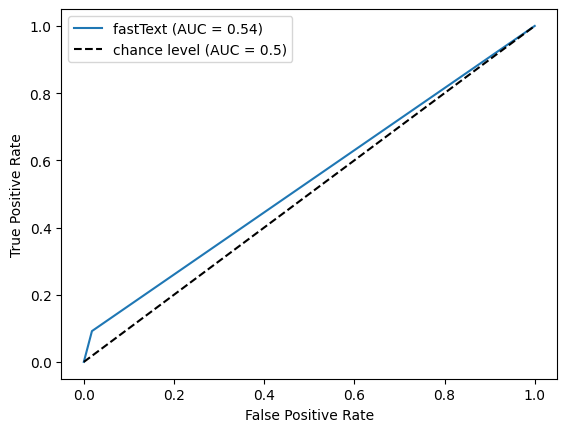

In [63]:
fpr, tpr, thresholds = roc_curve(dataset["test"]["label"], predicted_labels_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='fastText')
display.plot()
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.show()

In [64]:
%%time
# Model with lr 0.5
model2 = fasttext.train_supervised(input = "train.txt", lr = 0.5)

Wall time: 37.7 s


In [65]:
predictions2 = model2.predict(dataset["validation"]["sentence"])
predicted_labels2 = [eval(predictions2[0][i][0][-1]) for i in range(len(predictions2[0]))]

In [66]:
f1_valid2 = f1.compute(references = dataset["validation"]["label"], predictions = predicted_labels2, 
                      average = "weighted")
print("f1 on validation split:", f1_valid2)

f1 on validation split: {'f1': 0.7719017286780449}


In [67]:
# Evaluating the model on the test split
predictions_test2 = model2.predict(dataset["test"]["sentence"])
predicted_labels_test2 = [eval(predictions_test2[0][i][0][-1]) for i in range(len(predictions_test2[0]))]

f1_test2 = f1.compute(references = dataset["test"]["label"], predictions = predicted_labels_test2, 
                      average = "weighted")
print("f1 on test split:", f1_test2)

f1 on test split: {'f1': 0.7720871253537583}


In [68]:
print(classification_report(dataset["test"]["label"], predicted_labels_test2))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90    399496
           1       0.51      0.10      0.16     85377

    accuracy                           0.82    484873
   macro avg       0.67      0.54      0.53    484873
weighted avg       0.78      0.82      0.77    484873



In [69]:
roc_auc_score(dataset["test"]["label"], predicted_labels_test2)

0.5387546747943368

In [76]:
%%time
# Model with 10 epochs
model3 = fasttext.train_supervised(input = "train.txt", epoch = 25)

Wall time: 3min 19s


In [77]:
predictions3 = model3.predict(dataset["validation"]["sentence"])
predicted_labels3 = [eval(predictions3[0][i][0][-1]) for i in range(len(predictions3[0]))]

In [78]:
f1_valid3 = f1.compute(references = dataset["validation"]["label"], predictions = predicted_labels3, 
                      average = "weighted")
print("f1 on validation split:", f1_valid3)

f1 on validation split: {'f1': 0.77338093521616}


In [79]:
# Evaluating the model on the test split
predictions_test3 = model3.predict(dataset["test"]["sentence"])
predicted_labels_test3 = [eval(predictions_test3[0][i][0][-1]) for i in range(len(predictions_test3[0]))]

f1_test3 = f1.compute(references = dataset["test"]["label"], predictions = predicted_labels_test3, 
                      average = "weighted")
print("f1 on test split:", f1_test3)

f1 on test split: {'f1': 0.7735547369530243}


In [80]:
print(classification_report(dataset["test"]["label"], predicted_labels_test3))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90    399496
           1       0.49      0.11      0.18     85377

    accuracy                           0.82    484873
   macro avg       0.67      0.54      0.54    484873
weighted avg       0.78      0.82      0.77    484873



In [81]:
roc_auc_score(dataset["test"]["label"], predicted_labels_test3)

0.5419728068951968

In [82]:
%%time
# Using word n-grams
model_ng1 = fasttext.train_supervised(input = "train.txt", wordNgrams = 2)

Wall time: 1min 15s


In [83]:
predictions_ng1 = model_ng1.predict(dataset["validation"]["sentence"])
predicted_labels_ng1 = [eval(predictions_ng1[0][i][0][-1]) for i in range(len(predictions_ng1[0]))]

In [84]:
f1_valid_ng1 = f1.compute(references = dataset["validation"]["label"], predictions = predicted_labels_ng1, 
                      average = "weighted")
print("f1 on validation split:", f1_valid_ng1)

f1 on validation split: {'f1': 0.7871629211871046}


In [85]:
# Evaluating the model on the test split
predictions_test4 = model_ng1.predict(dataset["test"]["sentence"])
predicted_labels_test4 = [eval(predictions_test4[0][i][0][-1]) for i in range(len(predictions_test4[0]))]

f1_test4 = f1.compute(references = dataset["test"]["label"], predictions = predicted_labels_test4, 
                      average = "weighted")
print("f1 on test split:", f1_test4)

f1 on test split: {'f1': 0.78802004433695}


In [86]:
print(classification_report(dataset["test"]["label"], predicted_labels_test4))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90    399496
           1       0.46      0.21      0.29     85377

    accuracy                           0.82    484873
   macro avg       0.65      0.58      0.59    484873
weighted avg       0.78      0.82      0.79    484873



In [87]:
roc_auc_score(dataset["test"]["label"], predicted_labels_test4)

0.5778307245129966

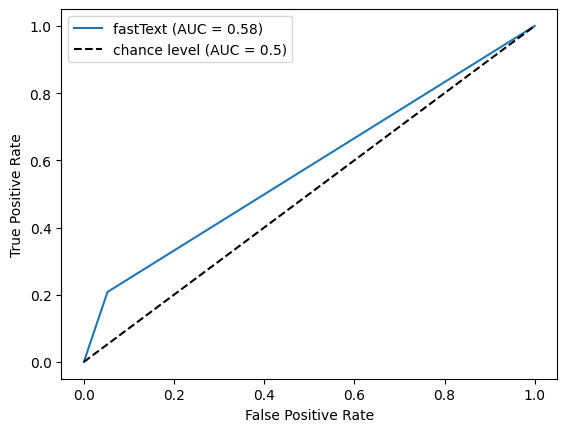

In [88]:
fpr, tpr, thresholds = roc_curve(dataset["test"]["label"], predicted_labels_test4)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='fastText')
display.plot()
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.show()

In [89]:
%%time
# Model with lr 0.5
model5 = fasttext.train_supervised(input = "train.txt", lr = 0.5, epoch = 25, wordNgrams = 2)

Wall time: 3min 44s


In [90]:
predictions5 = model5.predict(dataset["validation"]["sentence"])
predicted_labels5 = [eval(predictions5[0][i][0][-1]) for i in range(len(predictions5[0]))]

In [91]:
f1_valid5 = f1.compute(references = dataset["validation"]["label"], predictions = predicted_labels5, 
                      average = "weighted")
print("f1 on validation split:", f1_valid5)

f1 on validation split: {'f1': 0.7562856469281737}


In [92]:
# Evaluating the model on the test split
predictions_test5 = model5.predict(dataset["test"]["sentence"])
predicted_labels_test5 = [eval(predictions_test5[0][i][0][-1]) for i in range(len(predictions_test5[0]))]

f1_test5 = f1.compute(references = dataset["test"]["label"], predictions = predicted_labels_test5, 
                      average = "weighted")
print("f1 on test split:", f1_test5)

f1 on test split: {'f1': 0.7555500689433823}


In [93]:
print(classification_report(dataset["test"]["label"], predicted_labels_test5))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85    399496
           1       0.31      0.31      0.31     85377

    accuracy                           0.75    484873
   macro avg       0.58      0.58      0.58    484873
weighted avg       0.76      0.75      0.76    484873



In [94]:
roc_auc_score(dataset["test"]["label"], predicted_labels_test5)

0.5814230320730843

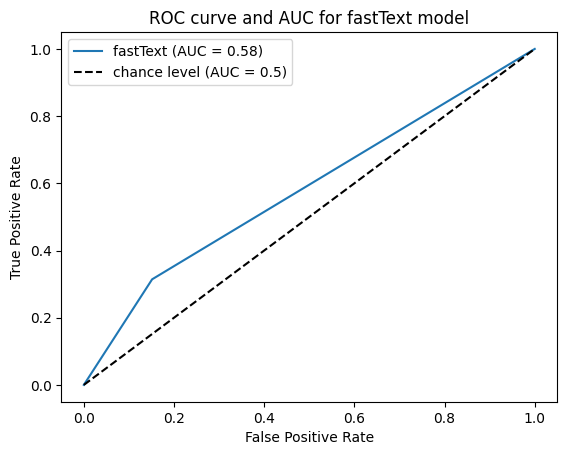

In [124]:
fpr, tpr, thresholds = roc_curve(dataset["test"]["label"], predicted_labels_test5)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='fastText')
display.plot()
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.title("ROC curve and AUC for fastText model")
plt.show()

In [117]:
%%time
model6 = fasttext.train_supervised(input = "train.txt", lr = 0.5, epoch = 30, wordNgrams = 2)

Wall time: 5min


In [118]:
predictions6 = model6.predict(dataset["validation"]["sentence"])
predicted_labels6 = [eval(predictions6[0][i][0][-1]) for i in range(len(predictions6[0]))]

In [119]:
f1_valid6 = f1.compute(references = dataset["validation"]["label"], predictions = predicted_labels6, 
                      average = "weighted")
print("f1 on validation split:", f1_valid6)

f1 on validation split: {'f1': 0.7483544681430766}


In [120]:
# Evaluating the model on the test split
predictions_test6 = model6.predict(dataset["test"]["sentence"])
predicted_labels_test6 = [eval(predictions_test6[0][i][0][-1]) for i in range(len(predictions_test6[0]))]

f1_test6 = f1.compute(references = dataset["test"]["label"], predictions = predicted_labels_test6, 
                      average = "weighted")
print("f1 on test split:", f1_test6)

f1 on test split: {'f1': 0.7480238249041039}


In [121]:
print(classification_report(dataset["test"]["label"], predicted_labels_test6))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84    399496
           1       0.29      0.33      0.31     85377

    accuracy                           0.74    484873
   macro avg       0.57      0.58      0.58    484873
weighted avg       0.75      0.74      0.75    484873



In [122]:
roc_auc_score(dataset["test"]["label"], predicted_labels_test6)

0.5792687687624887

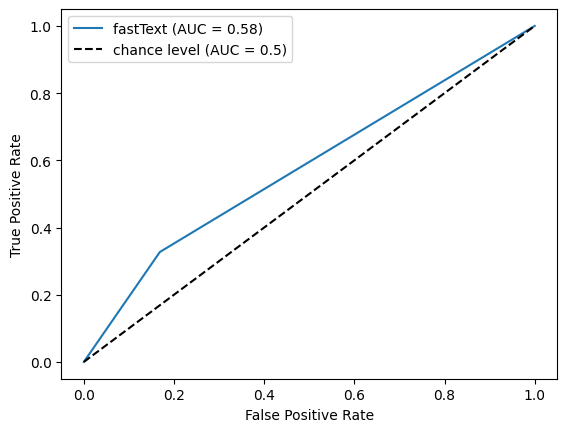

In [123]:
fpr, tpr, thresholds = roc_curve(dataset["test"]["label"], predicted_labels_test6)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='fastText')
display.plot()
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.show()